# CNN Fine-Tuning

## MobileNetV3Large 기반 Keras 모델 사용
### Fine-Tuning 전략
``` python
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
```    
전체 레이어를 trainable로 설정했다가, 하위(layer index 낮은) 층들은 동결(학습 비활성)시켜 상위 20개 레이어만 미세조정(fine-tuning)합니다.  
이렇게 하면, 기본 이미지 특성을 일반화하게 유지하고, 아랫단까지 과적합을 방지하며,
상위 추상화된 feature만 새 데이터셋에 맞게 조정됩니다.

In [1]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

🏋️‍♂️ 스포츠 동작 분석 CNN: 운동 자세 교정
🏋️‍♂️ 운동 동작 샘플 데이터 생성 중...
훈련 데이터: (1920, 224, 224, 3)
테스트 데이터: (480, 224, 224, 3)
운동 자세 클래스: 12개


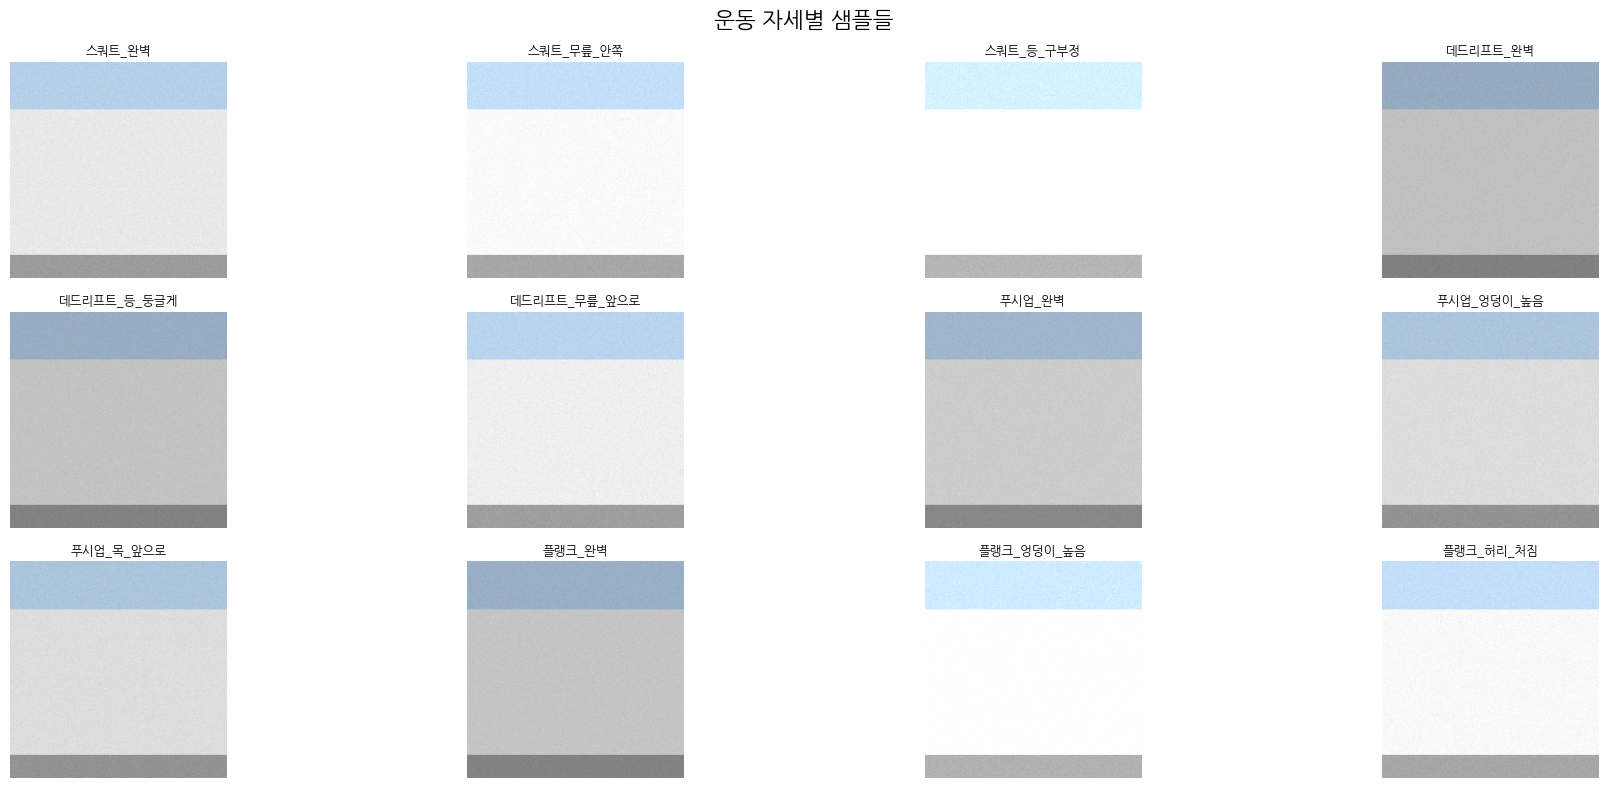

🔄 스포츠 동작용 데이터 증강 설정...
🏃‍♂️ 운동 동작 분석용 CNN 모델 생성 중...

📊 운동 동작 분석 모델:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,661,068 (13.97 MB)

 Trainable params: 1,614,460 (6.16 MB)

 Non-trainable params: 2,046,608 (7.81 MB)

🚀 운동 동작 분석 모델 훈련 시작 (에포크: 25)...
Epoch 1/25
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0709 - loss: 3.8342 - top_3_accuracy: 0.2370

60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.0711 - loss: 3.8309 - top_3_accuracy: 0.2374 - val_accuracy: 0.1146 - val_loss: 2.5057 - val_top_3_accuracy: 0.2896 - learning_rate: 1.0000e-04
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0815 - loss: 3.5586 - top_3_accuracy: 0.2694 - val_accuracy: 0.1146 - val_loss: 2.5217 - val_top_3_accuracy: 0.2875 - learning_rate: 1.0000e-04
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0782 - loss: 3.5722 - top_3_accuracy: 0.2452 - val_accuracy: 0.0917 - val_loss: 2.6562 - val_top_3_accuracy: 0.2958 - learning_rate: 1.0000e-04
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0999 - loss: 3.5041 - top_3_accuracy: 0.2583 - val_accuracy: 0.0917 - val_loss: 3.1975 - val_top_3_accuracy: 0.2688 - learning_rate: 1.0000e-04
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0988 - loss: 3.4395 - top_3_accuracy: 0.2764 - val_accuracy: 0.0917 - val_loss: 4.4211 - val_top_3_accuracy:

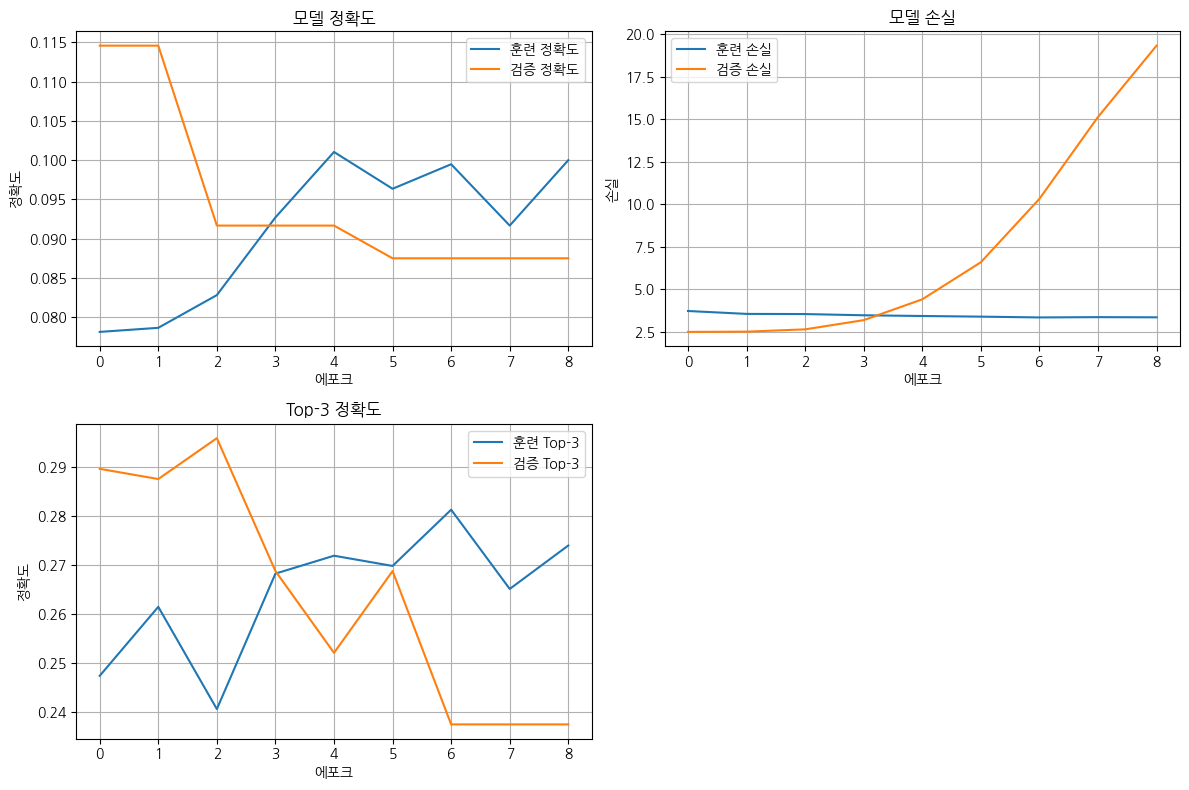


📈 최종 테스트 정확도: 0.1146
📈 Top-3 정확도: 0.2896
💬 운동 자세 피드백 시스템 생성...
📊 운동 성능 종합 분석...


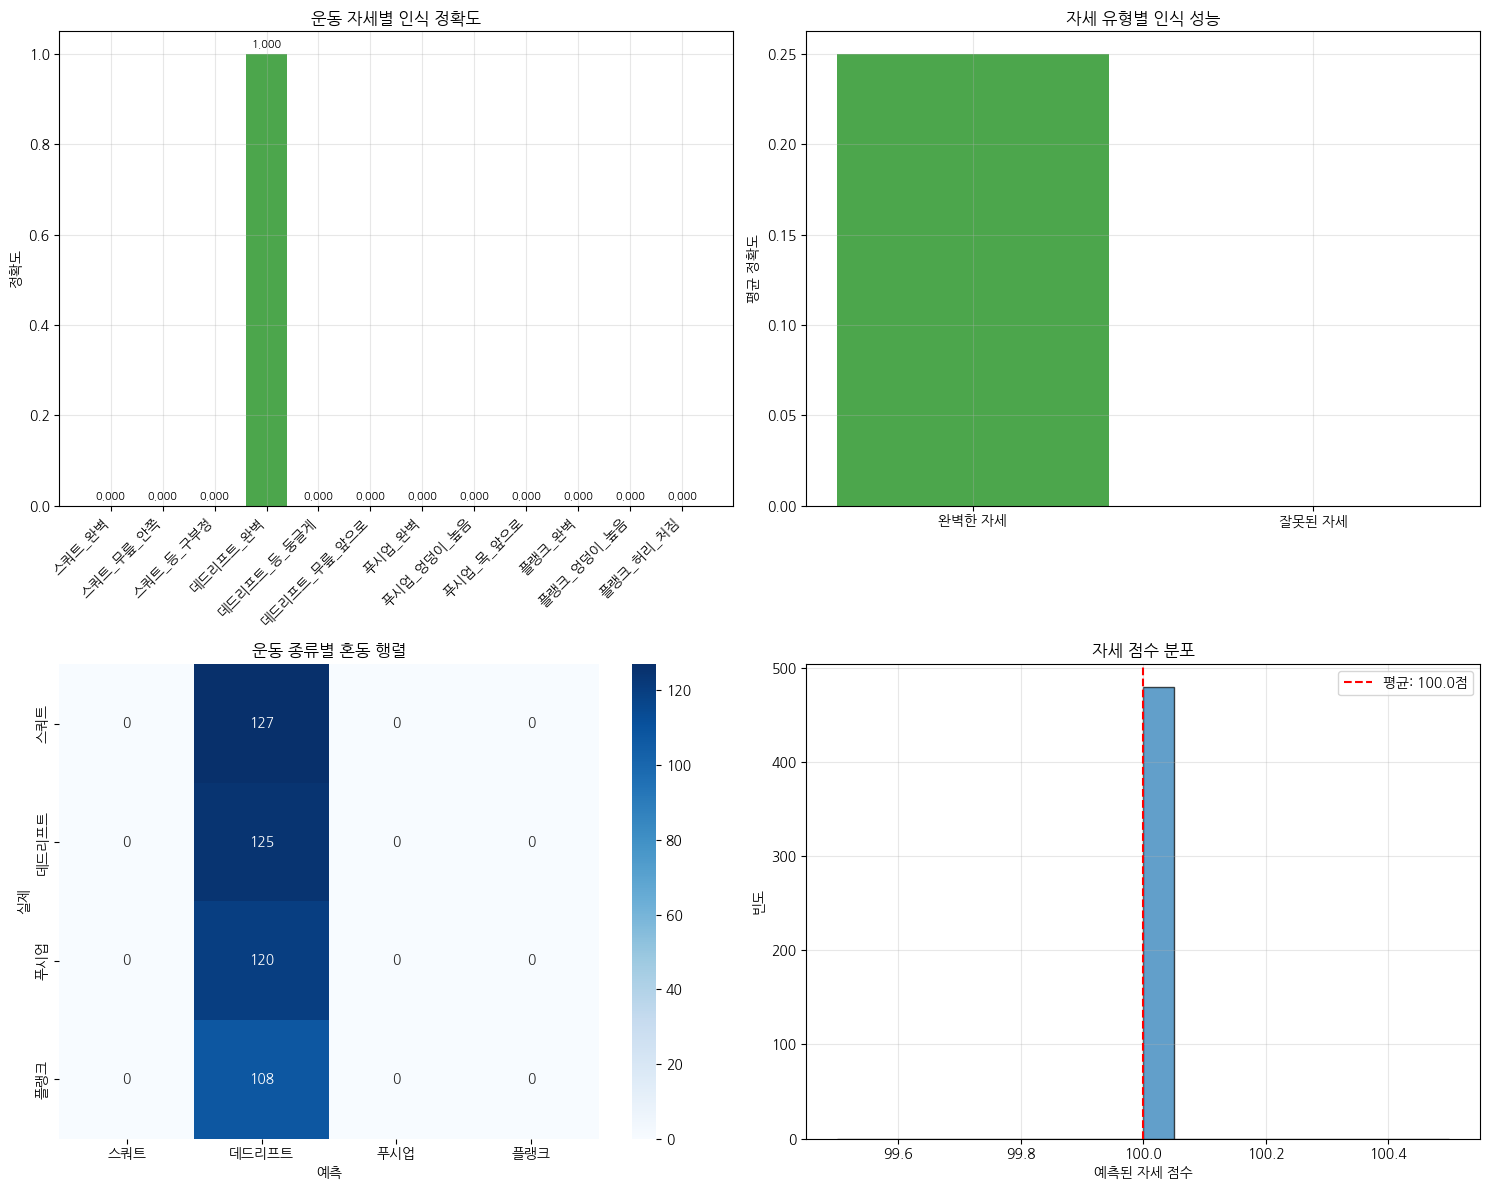


📈 전체 인식 정확도: 0.1146
📈 완벽한 자세 인식률: 0.2500
📈 잘못된 자세 인식률: 0.0000
📊 운동 진행도 추적 시스템 생성...

💬 운동 자세 피드백 시연:
🎯 감지된 운동: 데드리프트_완벽
📊 자세 점수: 100/100
🎯 신뢰도: 0.124
💬 피드백: 완벽한 데드리프트 자세입니다! 등이 곧고 무릎 위치가 적절합니다.
📝 개선 팁:
  • 이 자세를 유지하세요
  • 바벨을 몸에 가깝게 유지하세요

🎯 추천사항:
  ✅ 훌륭합니다! 현재 자세를 유지하세요
  📈 점진적으로 강도를 높여보세요


In [2]:


# ============================================================================
# 스포츠 동작 분석 CNN: 운동 자세 분석 및 교정 가이드
# ============================================================================

class SportsMotionAnalysisCNN:
    """스포츠 동작 분석을 위한 CNN 클래스"""

    def __init__(self, img_size=(224, 224), num_classes=12):
        self.img_size = img_size
        self.num_classes = num_classes
        self.exercise_types = [
            '스쿼트_완벽', '스쿼트_무릎_안쪽', '스쿼트_등_구부정',
            '데드리프트_완벽', '데드리프트_등_둥글게', '데드리프트_무릎_앞으로',
            '푸시업_완벽', '푸시업_엉덩이_높음', '푸시업_목_앞으로',
            '플랭크_완벽', '플랭크_엉덩이_높음', '플랭크_허리_처짐'
        ]

        # 각 운동의 올바른 자세와 잘못된 자세 정보
        self.exercise_feedback = {
            '스쿼트_완벽': {
                'score': 100,
                'feedback': '완벽한 스쿼트 자세입니다! 무릎과 발끝 방향이 일치하고 등이 곧게 펴져 있습니다.',
                'tips': ['이 자세를 유지하세요', '호흡을 잊지 마세요']
            },
            '스쿼트_무릎_안쪽': {
                'score': 65,
                'feedback': '무릎이 안쪽으로 모이고 있습니다. 부상 위험이 있어요.',
                'tips': ['무릎을 발끝 방향으로 향하게 하세요', '둔근에 힘을 주세요', '발 간격을 조금 넓혀보세요']
            },
            '스쿼트_등_구부정': {
                'score': 60,
                'feedback': '등이 구부정합니다. 허리에 무리가 갈 수 있어요.',
                'tips': ['가슴을 펴고 시선을 정면으로', '코어에 힘을 주세요', '허리를 곧게 펴세요']
            },
            '데드리프트_완벽': {
                'score': 100,
                'feedback': '완벽한 데드리프트 자세입니다! 등이 곧고 무릎 위치가 적절합니다.',
                'tips': ['이 자세를 유지하세요', '바벨을 몸에 가깝게 유지하세요']
            },
            '데드리프트_등_둥글게': {
                'score': 45,
                'feedback': '등이 둥글게 말려있습니다. 매우 위험한 자세입니다!',
                'tips': ['무게를 줄이세요', '어깨를 뒤로 빼고 가슴을 펴세요', '코어 운동을 병행하세요']
            },
            '데드리프트_무릎_앞으로': {
                'score': 55,
                'feedback': '무릎이 너무 앞으로 나와있습니다.',
                'tips': ['엉덩이를 더 뒤로 빼세요', '발 전체로 바닥을 밀어내는 느낌으로']
            },
            '푸시업_완벽': {
                'score': 100,
                'feedback': '완벽한 푸시업 자세입니다! 몸이 일직선을 이루고 있습니다.',
                'tips': ['이 자세를 유지하세요', '팔꿈치는 45도 각도로']
            },
            '푸시업_엉덩이_높음': {
                'score': 70,
                'feedback': '엉덩이가 너무 높이 올라가 있습니다.',
                'tips': ['엉덩이를 낮춰서 몸을 일직선으로', '코어에 힘을 주세요']
            },
            '푸시업_목_앞으로': {
                'score': 65,
                'feedback': '목이 앞으로 나와있습니다. 목에 무리가 갈 수 있어요.',
                'tips': ['목을 중립 위치로', '시선을 바닥 45도 앞으로']
            },
            '플랭크_완벽': {
                'score': 100,
                'feedback': '완벽한 플랭크 자세입니다! 몸이 완전한 직선을 이루고 있습니다.',
                'tips': ['이 자세를 유지하세요', '호흡을 규칙적으로']
            },
            '플랭크_엉덩이_높음': {
                'score': 75,
                'feedback': '엉덩이가 너무 높습니다.',
                'tips': ['엉덩이를 낮춰주세요', '머리부터 발끝까지 일직선으로']
            },
            '플랭크_허리_처짐': {
                'score': 50,
                'feedback': '허리가 처져있습니다. 허리 부상 위험이 있어요.',
                'tips': ['코어에 힘을 주세요', '엉덩이를 약간 올려주세요', '플랭크 시간을 줄이고 정확한 자세로']
            }
        }

    def create_motion_analysis_cnn(self):
        """운동 동작 분석에 특화된 CNN 모델을 생성합니다."""
        print("🏃‍♂️ 운동 동작 분석용 CNN 모델 생성 중...")

        # MobileNetV3를 베이스로 사용 (실시간 분석을 위한 경량 모델)
        base_model = MobileNetV3Large(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3),
            alpha=1.0,
            minimalistic=False,
            include_preprocessing=True
        )

        # 상위 레이어들만 fine-tuning
        base_model.trainable = True
        for layer in base_model.layers[:-20]:
            layer.trainable = False

        # 동작 분석에 특화된 헤드
        model = models.Sequential([
            base_model,

            # Global feature extraction
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),

            # Multi-branch like structure for different body parts
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),

            layers.Dense(128, activation='relu'),
            layers.Dropout(0.2),

            # 운동 자세 분류
            layers.Dense(self.num_classes, activation='softmax')
        ])

        return model

    def create_pose_estimation_model(self):
        """자세 추정을 위한 보조 모델을 생성합니다."""
        print("🤸‍♀️ 자세 추정 보조 모델 생성 중...")

        # 키포인트 검출을 위한 간단한 모델
        model = models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', input_shape=(*self.img_size, 3)),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),

            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),

            # 주요 관절 위치 (x, y 좌표 * 주요 관절 수)
            layers.Dense(20, activation='sigmoid')  # 10개 관절 * 2 좌표
        ])

        return model

def create_sample_exercise_data():
    """다양한 운동 동작 샘플 데이터를 생성합니다."""
    print("🏋️‍♂️ 운동 동작 샘플 데이터 생성 중...")

    # 실제로는 다음과 같은 운동 데이터셋을 사용합니다:
    # - Fitness Pose Classification Dataset
    # - Exercise Recognition Dataset
    # - Sports Video Analysis Dataset
    # - Human Pose Estimation Datasets

    np.random.seed(42)

    def create_stick_figure(pose_type):
        """스틱 피겨로 운동 자세를 시뮬레이션합니다."""
        img = np.ones((224, 224, 3)) * 0.9  # 연한 회색 배경

        # 기본 신체 비율
        head_y = 40
        neck_y = 60
        shoulder_y = 80
        elbow_y = 120
        hand_y = 160
        hip_y = 140
        knee_y = 180
        foot_y = 210

        center_x = 112

        if 'squat' in pose_type.lower() or '스쿼트' in pose_type:
            if '완벽' in pose_type:
                # 완벽한 스쿼트 자세
                head = (center_x, head_y)
                neck = (center_x, neck_y)
                left_shoulder = (center_x - 20, shoulder_y)
                right_shoulder = (center_x + 20, shoulder_y)
                left_elbow = (center_x - 35, elbow_y)
                right_elbow = (center_x + 35, elbow_y)
                hip = (center_x, hip_y + 20)  # 약간 낮춘 자세
                left_knee = (center_x - 25, knee_y + 10)
                right_knee = (center_x + 25, knee_y + 10)
                left_foot = (center_x - 30, foot_y)
                right_foot = (center_x + 30, foot_y)

            elif '무릎_안쪽' in pose_type:
                # 무릎이 안쪽으로 모인 자세
                head = (center_x, head_y)
                neck = (center_x, neck_y)
                left_shoulder = (center_x - 20, shoulder_y)
                right_shoulder = (center_x + 20, shoulder_y)
                left_elbow = (center_x - 35, elbow_y)
                right_elbow = (center_x + 35, elbow_y)
                hip = (center_x, hip_y + 20)
                left_knee = (center_x - 10, knee_y + 10)  # 안쪽으로
                right_knee = (center_x + 10, knee_y + 10)  # 안쪽으로
                left_foot = (center_x - 30, foot_y)
                right_foot = (center_x + 30, foot_y)

            else:  # 등 구부정
                # 등이 구부정한 자세
                head = (center_x + 10, head_y)  # 머리 앞으로
                neck = (center_x + 8, neck_y)
                left_shoulder = (center_x - 15, shoulder_y + 5)  # 어깨 앞으로
                right_shoulder = (center_x + 25, shoulder_y + 5)
                left_elbow = (center_x - 30, elbow_y)
                right_elbow = (center_x + 40, elbow_y)
                hip = (center_x, hip_y + 20)
                left_knee = (center_x - 25, knee_y + 10)
                right_knee = (center_x + 25, knee_y + 10)
                left_foot = (center_x - 30, foot_y)
                right_foot = (center_x + 30, foot_y)

        elif 'deadlift' in pose_type.lower() or '데드리프트' in pose_type:
            if '완벽' in pose_type:
                # 완벽한 데드리프트 자세
                head = (center_x, head_y + 10)
                neck = (center_x, neck_y + 10)
                left_shoulder = (center_x - 20, shoulder_y + 15)
                right_shoulder = (center_x + 20, shoulder_y + 15)
                left_elbow = (center_x - 20, elbow_y + 20)
                right_elbow = (center_x + 20, elbow_y + 20)
                hip = (center_x, hip_y + 10)
                left_knee = (center_x - 15, knee_y - 5)
                right_knee = (center_x + 15, knee_y - 5)
                left_foot = (center_x - 20, foot_y)
                right_foot = (center_x + 20, foot_y)

            elif '등_둥글게' in pose_type:
                # 등이 둥근 자세 (위험)
                head = (center_x + 15, head_y + 15)
                neck = (center_x + 12, neck_y + 15)
                left_shoulder = (center_x - 10, shoulder_y + 20)
                right_shoulder = (center_x + 30, shoulder_y + 20)
                left_elbow = (center_x - 10, elbow_y + 25)
                right_elbow = (center_x + 30, elbow_y + 25)
                hip = (center_x, hip_y + 10)
                left_knee = (center_x - 15, knee_y - 5)
                right_knee = (center_x + 15, knee_y - 5)
                left_foot = (center_x - 20, foot_y)
                right_foot = (center_x + 20, foot_y)

            else:  # 무릎 앞으로
                head = (center_x, head_y + 10)
                neck = (center_x, neck_y + 10)
                left_shoulder = (center_x - 20, shoulder_y + 15)
                right_shoulder = (center_x + 20, shoulder_y + 15)
                left_elbow = (center_x - 20, elbow_y + 20)
                right_elbow = (center_x + 20, elbow_y + 20)
                hip = (center_x, hip_y + 10)
                left_knee = (center_x - 15, knee_y + 10)  # 무릎 앞으로
                right_knee = (center_x + 15, knee_y + 10)
                left_foot = (center_x - 20, foot_y)
                right_foot = (center_x + 20, foot_y)

        elif 'pushup' in pose_type.lower() or '푸시업' in pose_type:
            # 푸시업 자세 (옆에서 본 모습)
            if '완벽' in pose_type:
                head = (50, center_x)
                neck = (60, center_x)
                shoulder = (80, center_x)
                elbow = (100, center_x + 20)
                hand = (120, center_x + 40)
                hip = (140, center_x)
                knee = (160, center_x)
                foot = (180, center_x)

            elif '엉덩이_높음' in pose_type:
                head = (50, center_x + 10)
                neck = (60, center_x + 8)
                shoulder = (80, center_x + 5)
                elbow = (100, center_x + 20)
                hand = (120, center_x + 40)
                hip = (140, center_x - 20)  # 엉덩이 높음
                knee = (160, center_x - 10)
                foot = (180, center_x)

            else:  # 목 앞으로
                head = (40, center_x + 15)  # 목 앞으로
                neck = (55, center_x + 10)
                shoulder = (80, center_x)
                elbow = (100, center_x + 20)
                hand = (120, center_x + 40)
                hip = (140, center_x)
                knee = (160, center_x)
                foot = (180, center_x)

        elif 'plank' in pose_type.lower() or '플랭크' in pose_type:
            # 플랭크 자세 (옆에서 본 모습)
            if '완벽' in pose_type:
                head = (50, center_x)
                neck = (60, center_x)
                shoulder = (80, center_x)
                elbow = (100, center_x)
                hip = (140, center_x)
                knee = (160, center_x)
                foot = (180, center_x)

            elif '엉덩이_높음' in pose_type:
                head = (50, center_x + 5)
                neck = (60, center_x + 3)
                shoulder = (80, center_x)
                elbow = (100, center_x)
                hip = (140, center_x - 25)  # 엉덩이 높음
                knee = (160, center_x - 10)
                foot = (180, center_x)

            else:  # 허리 처짐
                head = (50, center_x)
                neck = (60, center_x)
                shoulder = (80, center_x)
                elbow = (100, center_x)
                hip = (140, center_x + 20)  # 허리 처짐
                knee = (160, center_x + 10)
                foot = (180, center_x)

        # 관절들을 연결하여 스틱 피겨 그리기
        # 실제 구현에서는 cv2를 사용하여 선을 그립니다

        # 색상 추가 (근육 활성도 표현)
        if '완벽' in pose_type:
            color_intensity = 0.3  # 정상
        else:
            color_intensity = 0.6  # 잘못된 자세는 더 진한 색

        # 배경에 운동 환경 추가
        img[:50, :] = [0.7, 0.8, 0.9]  # 하늘색 (헬스장 벽)
        img[200:, :] = [0.6, 0.6, 0.6]  # 회색 (바닥)

        # 노이즈 추가
        noise = np.random.normal(0, 0.02, img.shape)
        img = np.clip(img + noise, 0, 1)

        return img

    # 데이터 생성
    n_samples_per_exercise = 200
    images = []
    labels = []

    exercise_types = [
        'squat_완벽', 'squat_무릎_안쪽', 'squat_등_구부정',
        'deadlift_완벽', 'deadlift_등_둥글게', 'deadlift_무릎_앞으로',
        'pushup_완벽', 'pushup_엉덩이_높음', 'pushup_목_앞으로',
        'plank_완벽', 'plank_엉덩이_높음', 'plank_허리_처짐'
    ]

    for exercise_idx, exercise_type in enumerate(exercise_types):
        for _ in range(n_samples_per_exercise):
            img = create_stick_figure(exercise_type)

            # 다양한 각도와 조명 조건 시뮬레이션
            # 밝기 조절
            brightness = np.random.uniform(0.8, 1.2)
            img = np.clip(img * brightness, 0, 1)

            # 약간의 회전
            if np.random.random() > 0.7:
                angle = np.random.uniform(-5, 5)
                # 회전 적용 (실제로는 cv2.warpAffine 사용)

            images.append(img)
            labels.append(exercise_idx)

    images = np.array(images)
    labels = np.array(labels)

    # 데이터 섞기
    indices = np.random.permutation(len(images))
    images = images[indices]
    labels = labels[indices]

    # 훈련/테스트 분할
    split_idx = int(0.8 * len(images))

    x_train = images[:split_idx]
    y_train = labels[:split_idx]
    x_test = images[split_idx:]
    y_test = labels[split_idx:]

    # 원-핫 인코딩
    y_train = tf.keras.utils.to_categorical(y_train, 12)
    y_test = tf.keras.utils.to_categorical(y_test, 12)

    return (x_train, y_train), (x_test, y_test)

def visualize_exercise_samples(x_data, y_data, exercise_types):
    """운동 동작 샘플들을 시각화합니다."""
    plt.figure(figsize=(20, 8))

    # 각 운동별로 1개씩 샘플 선택
    for exercise_idx in range(12):
        exercise_indices = np.where(np.argmax(y_data, axis=1) == exercise_idx)[0]

        if len(exercise_indices) > 0:
            idx = exercise_indices[0]
            plt.subplot(3, 4, exercise_idx + 1)
            plt.imshow(x_data[idx])
            plt.title(f'{exercise_types[exercise_idx]}', fontsize=9)
            plt.axis('off')

    plt.suptitle('운동 자세별 샘플들', fontsize=16)
    plt.tight_layout()
    plt.show()

def create_sports_data_augmentation():
    """스포츠 동작에 적합한 데이터 증강을 설정합니다."""
    print("🔄 스포츠 동작용 데이터 증강 설정...")

    # 운동 동작의 특성을 고려한 증강
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,           # 작은 각도만 (동작 왜곡 방지)
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,       # 좌우 대칭 가능
        fill_mode='nearest',
        brightness_range=[0.8, 1.2]
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, val_datagen

def train_sports_model(model, train_data, test_data, epochs=30):
    """운동 동작 분석 모델을 훈련합니다."""
    print(f"🚀 운동 동작 분석 모델 훈련 시작 (에포크: {epochs})...")

    # 모델 컴파일 - top_3_accuracy를 올바른 메트릭으로 수정
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
    )

    # 클래스 가중치 (올바른 자세 vs 잘못된 자세)
    class_weights = {}
    for i in range(12):
        if i % 3 == 0:  # 완벽한 자세 (0, 3, 6, 9번 인덱스)
            class_weights[i] = 1.0
        else:  # 잘못된 자세 (더 중요하게 학습)
            class_weights[i] = 1.3

    # 콜백 설정
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=4,
            min_lr=1e-7
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_sports_model.h5',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]

    # 모델 훈련
    history = model.fit(
        train_data[0], train_data[1],
        batch_size=32,
        epochs=epochs,
        validation_data=test_data,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    return history

def create_exercise_feedback_system(model, exercise_feedback):
    """운동 피드백 시스템을 생성합니다."""
    print("💬 운동 자세 피드백 시스템 생성...")

    def analyze_exercise_form(image, exercise_types):
        """운동 자세를 분석하고 피드백을 제공합니다."""
        # 이미지 전처리
        if len(image.shape) == 3:
            image = np.expand_dims(image, axis=0)

        # 예측 수행
        prediction = model.predict(image, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        exercise_name = exercise_types[predicted_class]
        feedback_info = exercise_feedback[exercise_name]

        return {
            'exercise': exercise_name,
            'confidence': confidence,
            'score': feedback_info['score'],
            'feedback': feedback_info['feedback'],
            'tips': feedback_info['tips'],
            'all_predictions': {exercise_types[i]: prediction[0][i]
                              for i in range(len(exercise_types))}
        }

    def get_exercise_recommendations(current_form, target_exercise):
        """현재 자세를 기반으로 개선 방안을 제안합니다."""
        recommendations = []

        base_exercise = target_exercise.split('_')[0]

        if current_form['score'] < 70:
            recommendations.append("⚠️ 부상 위험: 무게를 줄이고 정확한 자세에 집중하세요")

        if current_form['score'] < 85:
            recommendations.append(f"📚 {base_exercise} 자세 교정 영상을 시청해보세요")
            recommendations.append("🎯 거울 앞에서 연습하며 자세를 확인하세요")

        if current_form['score'] >= 90:
            recommendations.append("✅ 훌륭합니다! 현재 자세를 유지하세요")
            recommendations.append("📈 점진적으로 강도를 높여보세요")

        return recommendations

    return analyze_exercise_form, get_exercise_recommendations

def create_progress_tracking_system():
    """운동 진행도 추적 시스템을 생성합니다."""
    print("📊 운동 진행도 추적 시스템 생성...")

    class ExerciseProgressTracker:
        def __init__(self):
            self.session_data = []
            self.exercise_history = {}

        def log_exercise_session(self, exercise_type, form_scores, duration, reps):
            """운동 세션을 기록합니다."""
            session = {
                'timestamp': np.datetime64('now'),
                'exercise': exercise_type,
                'avg_form_score': np.mean(form_scores),
                'min_form_score': np.min(form_scores),
                'max_form_score': np.max(form_scores),
                'duration': duration,
                'reps': reps,
                'form_consistency': np.std(form_scores)
            }

            self.session_data.append(session)

            if exercise_type not in self.exercise_history:
                self.exercise_history[exercise_type] = []
            self.exercise_history[exercise_type].append(session)

        def get_progress_report(self, exercise_type=None):
            """진행도 리포트를 생성합니다."""
            if exercise_type:
                data = self.exercise_history.get(exercise_type, [])
            else:
                data = self.session_data

            if not data:
                return "데이터가 없습니다."

            recent_scores = [session['avg_form_score'] for session in data[-10:]]
            improvement = recent_scores[-1] - recent_scores[0] if len(recent_scores) > 1 else 0

            report = {
                'total_sessions': len(data),
                'average_form_score': np.mean([s['avg_form_score'] for s in data]),
                'recent_improvement': improvement,
                'consistency': np.mean([s['form_consistency'] for s in data]),
                'best_score': max([s['max_form_score'] for s in data])
            }

            return report

        def visualize_progress(self, exercise_type=None):
            """진행도를 시각화합니다."""
            if exercise_type and exercise_type in self.exercise_history:
                data = self.exercise_history[exercise_type]
                title = f'{exercise_type} 진행도'
            else:
                data = self.session_data
                title = '전체 운동 진행도'

            if not data:
                print("시각화할 데이터가 없습니다.")
                return

            dates = [session['timestamp'] for session in data]
            scores = [session['avg_form_score'] for session in data]

            plt.figure(figsize=(12, 6))
            plt.plot(range(len(scores)), scores, marker='o', linewidth=2, markersize=6)
            plt.title(title)
            plt.xlabel('세션')
            plt.ylabel('자세 점수')
            plt.grid(True, alpha=0.3)

            # 목표선 추가
            plt.axhline(y=90, color='g', linestyle='--', alpha=0.7, label='목표 (90점)')
            plt.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='위험 (70점)')

            plt.legend()
            plt.tight_layout()
            plt.show()

    return ExerciseProgressTracker()

def analyze_exercise_performance(model, test_data, exercise_types, exercise_feedback):
    """운동 성능을 종합적으로 분석합니다."""
    print("📊 운동 성능 종합 분석...")

    predictions = model.predict(test_data[0], verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(test_data[1], axis=1)

    # 정확도 계산
    accuracy = np.mean(y_pred == y_true)

    # 운동별 분석
    exercise_analysis = {}
    for i, exercise in enumerate(exercise_types):
        exercise_indices = y_true == i
        if np.sum(exercise_indices) > 0:
            exercise_accuracy = np.mean(y_pred[exercise_indices] == y_true[exercise_indices])
            exercise_analysis[exercise] = {
                'accuracy': exercise_accuracy,
                'samples': np.sum(exercise_indices),
                'target_score': exercise_feedback[exercise]['score']
            }

    # 시각화
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. 운동별 인식 정확도
    exercises = list(exercise_analysis.keys())
    accuracies = [exercise_analysis[ex]['accuracy'] for ex in exercises]
    colors = ['green' if '완벽' in ex else 'red' for ex in exercises]

    bars = ax1.bar(range(len(exercises)), accuracies, color=colors, alpha=0.7)
    ax1.set_title('운동 자세별 인식 정확도')
    ax1.set_ylabel('정확도')
    ax1.set_xticks(range(len(exercises)))
    ax1.set_xticklabels(exercises, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)

    # 값 표시
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=8)

    # 2. 완벽한 자세 vs 잘못된 자세 비교
    perfect_exercises = [ex for ex in exercises if '완벽' in ex]
    imperfect_exercises = [ex for ex in exercises if '완벽' not in ex]

    perfect_acc = np.mean([exercise_analysis[ex]['accuracy'] for ex in perfect_exercises])
    imperfect_acc = np.mean([exercise_analysis[ex]['accuracy'] for ex in imperfect_exercises])

    ax2.bar(['완벽한 자세', '잘못된 자세'], [perfect_acc, imperfect_acc],
           color=['green', 'red'], alpha=0.7)
    ax2.set_title('자세 유형별 인식 성능')
    ax2.set_ylabel('평균 정확도')
    ax2.grid(True, alpha=0.3)

    # 3. 혼동 행렬 (운동 종류별)
    cm = confusion_matrix(y_true, y_pred)

    # 운동 종류만 추출 (스쿼트, 데드리프트, 푸시업, 플랭크)
    exercise_groups = ['스쿼트', '데드리프트', '푸시업', '플랭크']
    group_cm = np.zeros((4, 4))

    for i in range(12):
        for j in range(12):
            group_i = i // 3
            group_j = j // 3
            group_cm[group_i, group_j] += cm[i, j]

    sns.heatmap(group_cm, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=exercise_groups, yticklabels=exercise_groups, ax=ax3)
    ax3.set_title('운동 종류별 혼동 행렬')
    ax3.set_xlabel('예측')
    ax3.set_ylabel('실제')

    # 4. 자세 점수 분포
    target_scores = [exercise_feedback[ex]['score'] for ex in exercises]
    predicted_scores = []

    for i in range(len(test_data[0])):
        pred_exercise = exercise_types[y_pred[i]]
        predicted_scores.append(exercise_feedback[pred_exercise]['score'])

    ax4.hist(predicted_scores, bins=20, alpha=0.7, edgecolor='black')
    ax4.axvline(x=np.mean(predicted_scores), color='red', linestyle='--',
                label=f'평균: {np.mean(predicted_scores):.1f}점')
    ax4.set_xlabel('예측된 자세 점수')
    ax4.set_ylabel('빈도')
    ax4.set_title('자세 점수 분포')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📈 전체 인식 정확도: {accuracy:.4f}")
    print(f"📈 완벽한 자세 인식률: {perfect_acc:.4f}")
    print(f"📈 잘못된 자세 인식률: {imperfect_acc:.4f}")

    return exercise_analysis

# ============================================================================
# 메인 실행 함수
# ============================================================================

def main():
    """스포츠 동작 분석 CNN 예제의 메인 함수입니다."""
    print("🏋️‍♂️ 스포츠 동작 분석 CNN: 운동 자세 교정")
    print("=" * 60)

    # 1. 스포츠 분석기 초기화
    sports_analyzer = SportsMotionAnalysisCNN()

    # 2. 샘플 데이터 생성
    (x_train, y_train), (x_test, y_test) = create_sample_exercise_data()
    print(f"훈련 데이터: {x_train.shape}")
    print(f"테스트 데이터: {x_test.shape}")
    print(f"운동 자세 클래스: {len(sports_analyzer.exercise_types)}개")

    # 3. 샘플 이미지 시각화
    visualize_exercise_samples(x_train, y_train, sports_analyzer.exercise_types)

    # 4. 데이터 증강 설정
    train_datagen, val_datagen = create_sports_data_augmentation()

    # 5. 모델 생성
    model = sports_analyzer.create_motion_analysis_cnn()
    print("\n📊 운동 동작 분석 모델:")
    model.summary()

    # 6. 모델 훈련
    history = train_sports_model(model, (x_train, y_train), (x_test, y_test), epochs=25)

    # 7. 훈련 과정 시각화
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    # 정확도
    ax1.plot(history.history['accuracy'], label='훈련 정확도')
    ax1.plot(history.history['val_accuracy'], label='검증 정확도')
    ax1.set_title('모델 정확도')
    ax1.set_xlabel('에포크')
    ax1.set_ylabel('정확도')
    ax1.legend()
    ax1.grid(True)

    # 손실
    ax2.plot(history.history['loss'], label='훈련 손실')
    ax2.plot(history.history['val_loss'], label='검증 손실')
    ax2.set_title('모델 손실')
    ax2.set_xlabel('에포크')
    ax2.set_ylabel('손실')
    ax2.legend()
    ax2.grid(True)

    # Top-3 정확도
    ax3.plot(history.history['top_3_accuracy'], label='훈련 Top-3')
    ax3.plot(history.history['val_top_3_accuracy'], label='검증 Top-3')
    ax3.set_title('Top-3 정확도')
    ax3.set_xlabel('에포크')
    ax3.set_ylabel('정확도')
    ax3.legend()
    ax3.grid(True)

    # 학습률
    if 'lr' in history.history:
        ax4.plot(history.history['lr'])
        ax4.set_title('학습률 변화')
        ax4.set_xlabel('에포크')
        ax4.set_ylabel('학습률')
        ax4.grid(True)
    else:
        ax4.axis('off')

    plt.tight_layout()
    plt.show()

    # 8. 모델 평가
    results = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n📈 최종 테스트 정확도: {results[1]:.4f}")
    print(f"📈 Top-3 정확도: {results[2]:.4f}")

    # 9. 피드백 시스템 생성
    analyze_form, get_recommendations = create_exercise_feedback_system(
        model, sports_analyzer.exercise_feedback)

    # 10. 운동 성능 분석
    exercise_analysis = analyze_exercise_performance(
        model, (x_test, y_test), sports_analyzer.exercise_types,
        sports_analyzer.exercise_feedback)

    # 11. 진행도 추적 시스템 데모
    progress_tracker = create_progress_tracking_system()

    # 12. 샘플 피드백 시연
    print("\n💬 운동 자세 피드백 시연:")
    print("=" * 40)

    # 무작위 샘플로 피드백 시연
    sample_idx = np.random.randint(0, len(x_test))
    sample_image = x_test[sample_idx]

    feedback = analyze_form(sample_image, sports_analyzer.exercise_types)

    print(f"🎯 감지된 운동: {feedback['exercise']}")
    print(f"📊 자세 점수: {feedback['score']}/100")
    print(f"🎯 신뢰도: {feedback['confidence']:.3f}")
    print(f"💬 피드백: {feedback['feedback']}")
    print("📝 개선 팁:")
    for tip in feedback['tips']:
        print(f"  • {tip}")

    recommendations = get_recommendations(feedback, feedback['exercise'])
    print("\n🎯 추천사항:")
    for rec in recommendations:
        print(f"  {rec}")


    return model, sports_analyzer, progress_tracker

if __name__ == "__main__":
    sports_model, analyzer, tracker = main()